# Recreating EP from NFL Play-by-Play Data

The code below represents my attempt to recreate the EP model that is included with the nfl_data_py play-by-play data. Expected Points (EP) represents the expected points that will be scored on a given drive given the available information about the current state of the game. This represents a concise approach to the problem with the XGBoost algorithm, implementing functions from across some Python packages I hadn't used before. I come largely as an R programmer, so some of the data manipulation work might strike the reader as functional; in exchange of pipelines in R, I have a preference for pandas method chaining. I'm happy to answer any questions about my code!

In [9]:
import pandas as pd
import nfl_data_py as nfl # for loading in data
import re
import numpy as np
import sklearn # for train/test split and also model
import xgboost as xgb # for model

In [10]:
# Load in five years of play-by-play data
pbp_raw = nfl.import_pbp_data(
    years=[i for i in range(2019,2024)],
    columns=['play_id','game_id','old_game_id','home_team','away_team','season_type','season','week',
            'posteam','posteam_type','defteam','side_of_field','yardline_100','game_date','quarter_seconds_remaining',
            'half_seconds_remaining','game_seconds_remaining','game_half','quarter_end','drive','sp','qtr','down','goal_to_go',
            'time','yrdln','ydstogo','ydsnet','desc','play_type','yards_gained','pass_length','air_yards','yards_after_catch',
            'posteam_score','defteam_score','score_differential','posteam_score_post','defteam_score_post','score_differential_post',
            'ep','epa','penalty','series','drive_play_count','fixed_drive','fixed_drive_result','penalty_yards','drive_ended_with_score',
            'aborted_play','home_opening_kickoff','special_teams_play','st_play_type','passer_player_name','rusher_player_name',
            'receiver_player_name','interception','fumble_forced','fumble_out_of_bounds','touchdown','fumble',
            'drive_play_id_started','drive_play_id_ended','timeout','field_goal_attempt','two_point_attempt',
             'posteam_timeouts_remaining','defteam_timeouts_remaining','penalty_type']
)

2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


## Methodological Notes
Although EPA models provide estimates on all types of plays, I wanted to limit this analysis to just runs and passes. To do this, the play-by-play data was filtered so that the 'play_type' field was either 'run' or 'pass'. Any additional field goal attempts and two point attempts have been filtered out as have any plays stopped by a delay of game penalty.

In [11]:
# function to get drive outcome by fixed_drive_result
def get_drive_outcome(result):
    if result == 'Field goal':
        return 3
    elif result == 'Touchdown':
        return 7
    elif result == 'Safety':
        return -2
    elif result == 'Opp touchdown':
        return -7
    else:
        return 0

# filter to needed subset of dataset, add outcome variable which is number of points scored on drive
pbp_processed = pbp_raw.query(
    'special_teams_play != 1 and play_type in ["run","pass"]\
    and field_goal_attempt != 1 and two_point_attempt != 1 and penalty_type != "Delay of Game"'
).assign(
    drive_outcome = lambda df: list(map(get_drive_outcome,df['fixed_drive_result']))
)

The defensive personnel fields were messy, so there were cases where the field listed a defensive team to have more/less than 11 players on the field. These observations were dropped. For other cases where the personnel was missing (~3% of observations), imputation was considered based on team tendencies for a given season. However, these observations were dropped instead due to perceived issues with this methodology and small sample size of the issue.

In [12]:
# function to use regex to get the number of players in personnel columns
def get_num_position(personnel,position = 'RB'):
    if pd.isna(personnel):
        return pd.NA
    out = re.findall(f'(\d+) {position}',personnel)
    if len(out) == 0:
        return 0
    else:
        return(float(out[0]))
    
# select variables for model dataframe, including identifiers, outcome, and features
model_df = pbp_processed.loc[
    :,
    ['play_id','game_id','fixed_drive','desc','drive_play_count','season',
     'home_team','away_team','posteam','defteam','play_type',# ID Variables
     
     'drive_outcome', # outcome variable
     
     'down','ydstogo','yardline_100','quarter_seconds_remaining',
     'half_seconds_remaining','game_seconds_remaining','score_differential',
     'offense_personnel','defense_personnel',# features
     'posteam_timeouts_remaining','defteam_timeouts_remaining']
].assign( # feature engineering with personnel
    num_rbs = lambda df: [get_num_position(i,position = 'RB') for i in df['offense_personnel'].tolist()],
    num_wrs = lambda df: [get_num_position(i,position = 'WR') for i in df['offense_personnel'].tolist()],
    num_tes = lambda df: [get_num_position(i,position = 'TE') for i in df['offense_personnel'].tolist()],
    num_dls = lambda df: [get_num_position(i,position = 'DL') for i in df['defense_personnel'].tolist()],
    num_lbs = lambda df: [get_num_position(i,position = 'LB') for i in df['defense_personnel'].tolist()],
    num_dbs = lambda df: [get_num_position(i,position = 'DB') for i in df['defense_personnel'].tolist()]
).assign(
    num_defenders = lambda df: df['num_dbs'] + df['num_dls'] + df['num_lbs']
).assign( # if num_defenders != 11, then coerce num_dls to NA
    num_dls = lambda df: list(
        pd.NA if pd.isna(df['num_defenders'].iloc[i]) or df['num_defenders'].iloc[i] != 11 \
        else df['num_dls'].iloc[i] for i in range(df.shape[0])
    ),
    num_lbs = lambda df: list(
        pd.NA if pd.isna(df['num_defenders'].iloc[i]) or df['num_defenders'].iloc[i] != 11 \
        else df['num_lbs'].iloc[i] for i in range(df.shape[0])
    ),
    num_dbs = lambda df: list(
        pd.NA if pd.isna(df['num_defenders'].iloc[i]) or df['num_defenders'].iloc[i] != 11 \
        else df['num_dbs'].iloc[i] for i in range(df.shape[0])
    )
) .drop(
    ['offense_personnel','defense_personnel','num_defenders'],
    axis = 1
).dropna()


In [13]:
# make down a dummy variable, create a unique id for each row as well
model_df_wdummies = pd.get_dummies(
    model_df.assign(
        down = [int(i) for i in model_df['down']],
        game_play_id = list(
            map(
                lambda x,y: str(x) + '-' + str(int(y)),
                model_df['game_id'],
                model_df['play_id']
            )
        )
    ),
    columns=['down']
)

model_features = ['game_play_id','ydstogo','yardline_100','quarter_seconds_remaining',
     'half_seconds_remaining','game_seconds_remaining','score_differential',
     'posteam_timeouts_remaining','defteam_timeouts_remaining','down_1','down_2','down_3','down_4']

## Modeling

In [14]:
# train test split, use 80% to train
import sklearn
X_train, X_test,y_train,y_test = sklearn.model_selection.train_test_split(
    model_df_wdummies[model_features],
    model_df_wdummies['drive_outcome'],
    test_size=0.2,
    random_state = 33 # for reproducibility
)

In [15]:
# sklearn implementation for base model before hyperparameter tuning
import xgboost as xgb
xgb_model_sklearn_init = xgb.XGBRegressor(
    max_depth = 5,
    n_estimators = 400,
    eta = 0.1,
    objective = 'reg:squarederror',
    eval_metric = 'rmse'
)
xgb_model_sklearn_init.fit(
    X_train.iloc[:,1:],
    y_train
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric='rmse',
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, ...)

In [16]:
# tuning the hyperparameters with grid search, consider 112 combinations
param_grid = {
    'max_depth':list(range(2,9)),
    'n_estimators':[400,500,600,700],
    'eta':[0.1,0.2,0.3,0.4],
    'objective':['reg:squarederror'],
    'eval_metric':['rmse']
}
xgb_gs = sklearn.model_selection.GridSearchCV(xgb_model_sklearn_init,param_grid,cv = 5)
xgb_gs.fit(
    X_train.iloc[:,1:],
    y_train
)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eta=0.1,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_r...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=5, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=400,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'eta': [0.1, 0.2, 0.3, 0.4], 'eval_metric': ['rmse'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8],
                         'n_estimators': [400, 500, 600, 700],
                         'objective': ['reg:squarederror']})

In [17]:
print(len(xgb_gs.cv_results_['params'])) # list of parameter combos
print(xgb_gs.best_params_) # best tune

112
{'eta': 0.1, 'eval_metric': 'rmse', 'max_depth': 7, 'n_estimators': 400, 'objective': 'reg:squarederror'}


In [18]:
# build and train the final model
xgb_final = xgb.XGBRegressor(
    eta = 0.1,
    eval_metric = 'rmse', 
    max_depth = 7, 
    n_estimators = 400, 
    objective = 'reg:squarederror'
)
xgb_final.fit(
    X_train.iloc[:,1:],
    y_train,
    eval_set = [(X_train.iloc[:,1:],y_train),(X_test.iloc[:,1:],y_test)]
)

[0]	validation_0-rmse:3.09973	validation_1-rmse:3.08135
[1]	validation_0-rmse:3.05312	validation_1-rmse:3.03578
[2]	validation_0-rmse:3.01447	validation_1-rmse:2.99807
[3]	validation_0-rmse:2.98237	validation_1-rmse:2.96717
[4]	validation_0-rmse:2.95574	validation_1-rmse:2.94157
[5]	validation_0-rmse:2.93348	validation_1-rmse:2.92041
[6]	validation_0-rmse:2.91520	validation_1-rmse:2.90338
[7]	validation_0-rmse:2.89952	validation_1-rmse:2.88882
[8]	validation_0-rmse:2.88658	validation_1-rmse:2.87710
[9]	validation_0-rmse:2.87584	validation_1-rmse:2.86767
[10]	validation_0-rmse:2.86667	validation_1-rmse:2.85960
[11]	validation_0-rmse:2.85874	validation_1-rmse:2.85299
[12]	validation_0-rmse:2.85207	validation_1-rmse:2.84732
[13]	validation_0-rmse:2.84664	validation_1-rmse:2.84316
[14]	validation_0-rmse:2.84182	validation_1-rmse:2.83951
[15]	validation_0-rmse:2.83747	validation_1-rmse:2.83633
[16]	validation_0-rmse:2.83378	validation_1-rmse:2.83377
[17]	validation_0-rmse:2.83021	validation

[144]	validation_0-rmse:2.71986	validation_1-rmse:2.79346
[145]	validation_0-rmse:2.71907	validation_1-rmse:2.79334
[146]	validation_0-rmse:2.71870	validation_1-rmse:2.79331
[147]	validation_0-rmse:2.71773	validation_1-rmse:2.79319
[148]	validation_0-rmse:2.71673	validation_1-rmse:2.79314
[149]	validation_0-rmse:2.71599	validation_1-rmse:2.79298
[150]	validation_0-rmse:2.71494	validation_1-rmse:2.79272
[151]	validation_0-rmse:2.71457	validation_1-rmse:2.79275
[152]	validation_0-rmse:2.71383	validation_1-rmse:2.79283
[153]	validation_0-rmse:2.71262	validation_1-rmse:2.79226
[154]	validation_0-rmse:2.71204	validation_1-rmse:2.79220
[155]	validation_0-rmse:2.71150	validation_1-rmse:2.79219
[156]	validation_0-rmse:2.71122	validation_1-rmse:2.79198
[157]	validation_0-rmse:2.71119	validation_1-rmse:2.79195
[158]	validation_0-rmse:2.71062	validation_1-rmse:2.79183
[159]	validation_0-rmse:2.70990	validation_1-rmse:2.79180
[160]	validation_0-rmse:2.70928	validation_1-rmse:2.79173
[161]	validati

[286]	validation_0-rmse:2.63870	validation_1-rmse:2.78383
[287]	validation_0-rmse:2.63825	validation_1-rmse:2.78387
[288]	validation_0-rmse:2.63752	validation_1-rmse:2.78384
[289]	validation_0-rmse:2.63715	validation_1-rmse:2.78392
[290]	validation_0-rmse:2.63685	validation_1-rmse:2.78396
[291]	validation_0-rmse:2.63648	validation_1-rmse:2.78393
[292]	validation_0-rmse:2.63633	validation_1-rmse:2.78388
[293]	validation_0-rmse:2.63617	validation_1-rmse:2.78382
[294]	validation_0-rmse:2.63598	validation_1-rmse:2.78384
[295]	validation_0-rmse:2.63550	validation_1-rmse:2.78379
[296]	validation_0-rmse:2.63430	validation_1-rmse:2.78327
[297]	validation_0-rmse:2.63365	validation_1-rmse:2.78322
[298]	validation_0-rmse:2.63325	validation_1-rmse:2.78327
[299]	validation_0-rmse:2.63280	validation_1-rmse:2.78340
[300]	validation_0-rmse:2.63222	validation_1-rmse:2.78340
[301]	validation_0-rmse:2.63172	validation_1-rmse:2.78334
[302]	validation_0-rmse:2.63107	validation_1-rmse:2.78330
[303]	validati

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric='rmse',
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, ...)

,diff_ep
avg_diff,0.723047


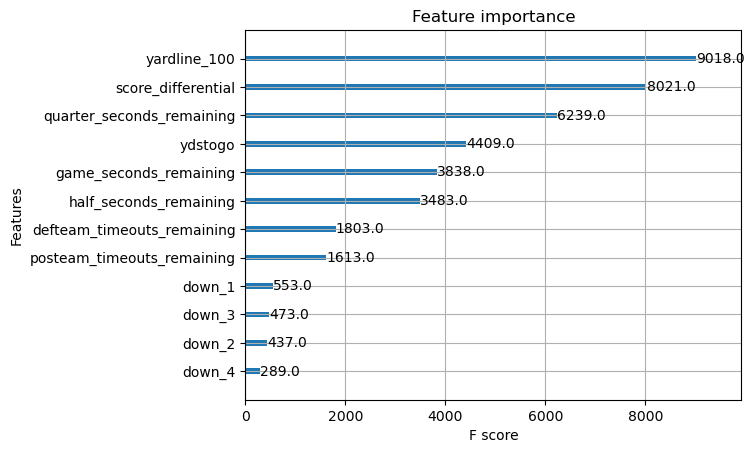

In [21]:
xgb.plot_importance(xgb_final) # variable importance plot
test_preds = xgb_final.predict(X_test.iloc[:,1:])
test_w_preds = X_test.assign(pred_ep = test_preds)

# how does the model do compared to the 'ep' field in original dataset
test_w_preds.merge(
    model_df_wdummies.loc[:,['game_play_id','game_id','play_id']],
    how = 'left',
    on = 'game_play_id'
).merge(
    pbp_raw.loc[:,['game_id','play_id','ep']],
    how = 'left',
    on = ['game_id','play_id']
).assign(
    diff_ep = lambda df: np.abs(df['pred_ep'] - df['ep'])
).aggregate(
    avg_diff = ('diff_ep',np.mean)
)

As we see in the last cell, the difference between our model and the expected points model included in the data is about 0.7 points on average. This difference makes sense given a couple of different reasons
    - a shorter list of features
    - a subset of data to train on excluding many types of plays included in the original model
    - the use of the XGBoost algorithm which could be different from the methodology used in the original model

Thanks for reading!